# **Extracting Information from Legal Documents Using RAG**

## **Objective**

The main objective of this assignment is to process and analyse a collection text files containing legal agreements (e.g., NDAs) to prepare them for implementing a **Retrieval-Augmented Generation (RAG)** system. This involves:

* Understand the Cleaned Data : Gain a comprehensive understanding of the structure, content, and context of the cleaned dataset.
* Perform Exploratory Analysis : Conduct bivariate and multivariate analyses to uncover relationships and trends within the cleaned data.
* Create Visualisations : Develop meaningful visualisations to support the analysis and make findings interpretable.
* Derive Insights and Conclusions : Extract valuable insights from the cleaned data and provide clear, actionable conclusions.
* Document the Process : Provide a detailed description of the data, its attributes, and the steps taken during the analysis for reproducibility and clarity.

The ultimate goal is to transform the raw text data into a clean, structured, and analysable format that can be effectively used to build and train a RAG system for tasks like information retrieval, question-answering, and knowledge extraction related to legal agreements.

### **Business Value**  


The project aims to leverage RAG to enhance legal document processing for businesses, law firms, and regulatory bodies. The key business objectives include:

* Faster Legal Research: <br> Reduce the time lawyers and compliance officers spend searching for relevant case laws, precedents, statutes, or contract clauses.
* Improved Contract Analysis: <br> Automatically extract key terms, obligations, and risks from lengthy contracts.
* Regulatory Compliance Monitoring: <br> Help businesses stay updated with legal and regulatory changes by retrieving relevant legal updates.
* Enhanced Decision-Making: <br> Provide accurate and context-aware legal insights to assist in risk assessment and legal strategy.


**Use Cases**
* Legal Chatbots
* Contract Review Automation
* Tracking Regulatory Changes and Compliance Monitoring
* Case Law Analysis of past judgments
* Due Diligence & Risk Assessment

## **1. Data Loading, Preparation and Analysis** <font color=red> [20 marks] </font><br>

### **1.1 Data Understanding**

The dataset contains legal documents and contracts collected from various sources. The documents are present as text files (`.txt`) in the *corpus* folder.

There are four types of documents in the *courpus* folder, divided into four subfolders.
- `contractnli`: contains various non-disclosure and confidentiality agreements
- `cuad`: contains contracts with annotated legal clauses
- `maud`: contains various merger/acquisition contracts and agreements
- `privacy_qa`: a question-answering dataset containing privacy policies

The dataset also contains evaluation files in JSON format in the *benchmark* folder. The files contain the questions and their answers, along with sources. For each of the above four folders, there is a `json` file: `contractnli.json`, `cuad.json`, `maud.json` `privacy_qa.json`. The file structure is as follows:

```
{
    "tests": [
        {
            "query": <question1>,
            "snippets": [{
                    "file_path": <source_file1>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 1>
                },
                {
                    "file_path": <source_file2>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 2>
                }, ....
            ]
        },
        {
            "query": <question2>,
            "snippets": [{<answer context for que 2>}]
        },
        ... <more queries>
    ]
}
```

### **1.2 Load and Preprocess the data** <font color=red> [5 marks] </font><br>

#### Loading libraries

In [1]:
#!pip install --upgrade streamlit

In [2]:
## The following libraries might be useful
# !pip install -q langchain-openai
# !pip install -U -q langchain-community
# !pip install -U -q langchain-chroma
# !pip install -U -q datasets
# !pip install -U -q ragas
# !pip install -U -q rouge_score

In [29]:
# Import essential libraries
import os, logging
os.environ["CHROMA_TELEMETRY_ENABLED"] = "false"
os.environ["CHROMA_LOG_LEVEL"] = "ERROR"

logging.getLogger("chromadb.telemetry.product.posthog").setLevel(logging.CRITICAL)
logging.getLogger("chromadb").setLevel(logging.ERROR)

import glob
import re
from typing import List, Dict
import seaborn as sns
import matplotlib.pyplot as plt


#### **1.2.1** <font color=red> [3 marks] </font>
Load all `.txt` files from the folders.

You can utilise document loaders from the options provided by the LangChain community.

Optionally, you can also read the files manually, while ensuring proper handling of encoding issues (e.g., utf-8, latin1). In such case, also store the file content along with metadata (e.g., file name, directory path) for traceability.

In [4]:
# Load the files as documents

import logging
from langchain_community.document_loaders import TextLoader
from langchain.docstore.document import Document

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def load_documents_from_corpus(corpus_dir: str = "rag_legal/corpus"):
    docs = []

    for subfolder in os.listdir(corpus_dir):
        folder_path = os.path.join(corpus_dir, subfolder)
        if not os.path.isdir(folder_path):
            continue

        for file_path in glob.glob(f"{folder_path}/*.txt"):
            try:
                loader = TextLoader(file_path, encoding="utf-8")
                loaded = loader.load()
                for doc in loaded:
                    doc.metadata["source"] = file_path
                    doc.metadata["doc_type"] = subfolder
                    docs.append(doc)
            except Exception as e:
                logger.warning(f"Fallback load for {file_path}")
                try:
                    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
                        content = f.read()
                        docs.append(Document(
                            page_content=content,
                            metadata={"source": file_path, "doc_type": subfolder}
                        ))
                except Exception as fallback_error:
                    logger.error(f"Could not load {file_path}: {fallback_error}")

    print(f"Loaded {len(docs)} documents.")
    return docs

raw_docs = load_documents_from_corpus("rag_legal/corpus")


Loaded 698 documents.


#### **1.2.2** <font color=red> [2 marks] </font>
Preprocess the text data to remove noise and prepare it for analysis.

Remove special characters, extra whitespace, and irrelevant content such as email and telephone contact info.
Normalise text (e.g., convert to lowercase, remove stop words).
Handle missing or corrupted data by logging errors and skipping problematic files.

In [5]:
# Clean and preprocess the data

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

STOPWORDS = set(stopwords.words('english'))

def clean_text(text: str):
    text = re.sub(r'\S+@\S+', '', text)  # Remove emails
    text = re.sub(r'\b\d{10,}\b', '', text)  # Remove long numbers (phone numbers)
    text = re.sub(r"[^a-zA-Z\s]", " ", text)  # Remove special chars
    text = re.sub(r'\s+', ' ', text)  # Normalize spaces
    text = text.lower()

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in STOPWORDS and len(word) > 1]

    return ' '.join(tokens)

def preprocess_documents(docs):
    cleaned = []
    for doc in docs:
        try:
            cleaned_text = clean_text(doc.page_content)
            if cleaned_text.strip():
                cleaned.append(Document(page_content=cleaned_text, metadata=doc.metadata))
        except Exception as e:
            logger.warning(f"Skipping doc: {doc.metadata.get('source')} — {e}")
    print(f"Cleaned {len(cleaned)} out of {len(docs)} documents.")
    return cleaned

cleaned_docs = preprocess_documents(raw_docs)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Adarsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Adarsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cleaned 698 out of 698 documents.


### **1.3 Exploratory Data Analysis** <font color=red> [10 marks] </font><br>

#### **1.3.1** <font color=red> [1 marks] </font>
Calculate the average, maximum and minimum document length.

In [6]:
# Calculate the average, maximum and minimum document length.

import numpy as np

def document_length_stats(docs):
    lengths = [len(doc.page_content.split()) for doc in docs]
    print(f"Total Documents: {len(docs)}")
    print(f"Average Length: {np.mean(lengths):.2f} words")
    print(f"Max Length: {np.max(lengths)} words")
    print(f"Min Length: {np.min(lengths)} words")
    return lengths

doc_lengths = document_length_stats(cleaned_docs)


Total Documents: 698
Average Length: 8534.52 words
Max Length: 81348 words
Min Length: 132 words


#### **1.3.2** <font color=red> [4 marks] </font>
Analyse the frequency of occurrence of words and find the most and least occurring words.

Find the 20 most common and least common words in the text. Ignore stop words such as articles and prepositions.

In [7]:
# Find frequency of occurence of words

from collections import Counter

def word_frequency_analysis(docs, top_n=20):
    all_words = []
    for doc in docs:
        all_words.extend([word for word in doc.page_content.split() if word not in STOPWORDS])
    counter = Counter(all_words)

    most_common = counter.most_common(top_n)
    least_common = counter.most_common()[-top_n:]

    print("Top 20 Most Frequent Words:")
    for word, count in most_common:
        print(f"{word}: {count}")

    print("\nTop 20 Least Frequent Words:")
    for word, count in least_common:
        print(f"{word}: {count}")

    return most_common, least_common

top_words, bottom_words = word_frequency_analysis(cleaned_docs)




Top 20 Most Frequent Words:
company: 156423
shall: 108019
agreement: 104658
section: 75450
parent: 60715
party: 54218
date: 39392
time: 35828
material: 34245
merger: 33907
subsidiaries: 33320
applicable: 31384
including: 29407
respect: 28849
may: 28116
stock: 26888
information: 25727
parties: 24641
business: 23706
prior: 23346

Top 20 Least Frequent Words:
leaderboards: 1
biographic: 1
idfa: 1
coarse: 1
gameboards: 1
invisibly: 1
outweigh: 1
recieve: 1
adcolony: 1
nodeid: 1
zingtree: 1
fb: 1
heyzap: 1
ironsrc: 1
pinsight: 1
pinsightmedia: 1
soomla: 1
soom: 1
youronlinechoices: 1
newer: 1


#### **1.3.3** <font color=red> [4 marks] </font>
Analyse the similarity of different documents to each other based on TF-IDF vectors.

Transform some documents to TF-IDF vectors and calculate their similarity matrix using a suitable distance function. If contracts contain duplicate or highly similar clauses, similarity calculation can help detect them.

Identify for the first 10 documents and then for 10 random documents. What do you observe?

Similarity matrix for docs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:

[[1.   0.25 0.61 0.5  0.52 0.57 0.58 0.72 0.43 0.55]
 [0.25 1.   0.26 0.2  0.22 0.23 0.22 0.24 0.25 0.24]
 [0.61 0.26 1.   0.66 0.71 0.72 0.74 0.77 0.41 0.7 ]
 [0.5  0.2  0.66 1.   0.58 0.63 0.63 0.62 0.3  0.59]
 [0.52 0.22 0.71 0.58 1.   0.61 0.62 0.63 0.32 0.61]
 [0.57 0.23 0.72 0.63 0.61 1.   0.72 0.63 0.37 0.69]
 [0.58 0.22 0.74 0.63 0.62 0.72 1.   0.67 0.39 0.68]
 [0.72 0.24 0.77 0.62 0.63 0.63 0.67 1.   0.35 0.62]
 [0.43 0.25 0.41 0.3  0.32 0.37 0.39 0.35 1.   0.4 ]
 [0.55 0.24 0.7  0.59 0.61 0.69 0.68 0.62 0.4  1.  ]]


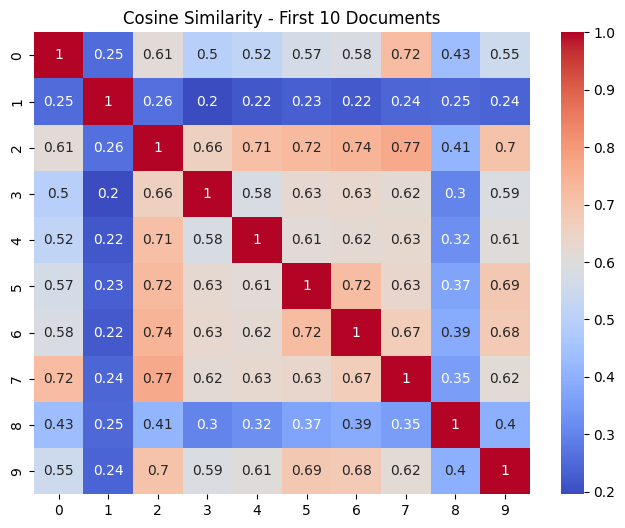

In [30]:
# Transform the page contents of documents

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity_matrix(docs, indices=None):
    if indices is None:
        indices = list(range(min(10, len(docs))))

    selected_texts = [docs[i].page_content for i in indices]
    vectorizer = TfidfVectorizer(max_features=5000)
    tfidf_matrix = vectorizer.fit_transform(selected_texts)
    similarity_matrix = cosine_similarity(tfidf_matrix)

    print(f"Similarity matrix for docs {indices}:\n")
    print(np.round(similarity_matrix, 2))
    return similarity_matrix


# Compute similarity scores

similarity_matrix_first_10 = compute_similarity_matrix(cleaned_docs, indices=list(range(10)))

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix_first_10, annot=True, cmap="coolwarm", xticklabels=range(10), yticklabels=range(10))
plt.title("Cosine Similarity - First 10 Documents")
plt.show()

In [9]:
# create a list of 10 random integers

import random
random_indices = random.sample(range(len(cleaned_docs)), min(10, len(cleaned_docs)))
print("Random indices selected:", random_indices)



Random indices selected: [251, 434, 604, 472, 341, 263, 334, 38, 185, 124]


Similarity matrix for docs [251, 434, 604, 472, 341, 263, 334, 38, 185, 124]:

[[1.   0.23 0.26 0.17 0.08 0.26 0.26 0.14 0.12 0.19]
 [0.23 1.   0.3  0.2  0.09 0.21 0.23 0.17 0.12 0.16]
 [0.26 0.3  1.   0.33 0.14 0.3  0.31 0.2  0.16 0.21]
 [0.17 0.2  0.33 1.   0.09 0.21 0.24 0.15 0.12 0.18]
 [0.08 0.09 0.14 0.09 1.   0.13 0.15 0.08 0.07 0.11]
 [0.26 0.21 0.3  0.21 0.13 1.   0.79 0.26 0.18 0.76]
 [0.26 0.23 0.31 0.24 0.15 0.79 1.   0.25 0.17 0.73]
 [0.14 0.17 0.2  0.15 0.08 0.26 0.25 1.   0.16 0.15]
 [0.12 0.12 0.16 0.12 0.07 0.18 0.17 0.16 1.   0.13]
 [0.19 0.16 0.21 0.18 0.11 0.76 0.73 0.15 0.13 1.  ]]


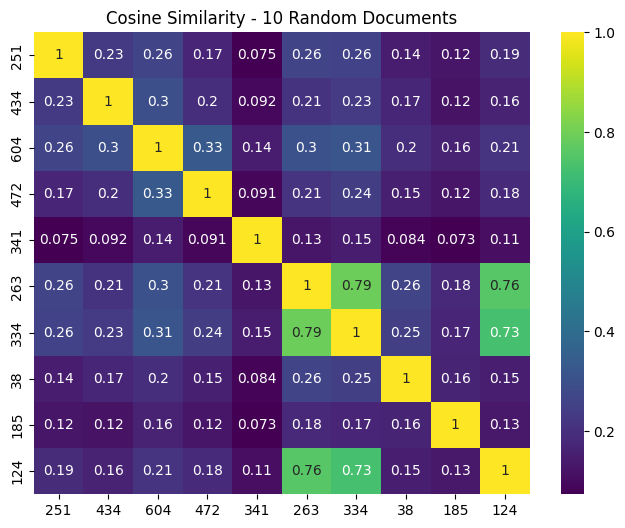

In [33]:
# Compute similarity scores for 10 random documents

similarity_matrix_random_10 = compute_similarity_matrix(cleaned_docs, indices=random_indices)

# Plot

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix_random_10, annot=True, cmap="viridis", xticklabels=random_indices, yticklabels=random_indices)
plt.title("Cosine Similarity - 10 Random Documents")
plt.show()

High similarity (values near 1.0) indicates duplicate or very similar clauses (common in legal contracts).

Diagonal = 1.0 (self-similarity).

There are clusters of similar documents, e.g., all NDAs might be similar to each other.

Clusters of high values suggest reused or boilerplate text — useful for detecting redundancy.

**Random documents** are **less likely to show high similarity** unless they happen to be from the same subfolder or topic.

There are **higher number of similarity scores** observed between the **first 10 documents** than the first 10 random documents as the first 10 documents are possibly from the **same folder**.

### **1.4 Document Creation and Chunking** <font color=red> [5 marks] </font><br>

#### **1.4.1** <font color=red> [5 marks] </font>
Perform appropriate steps to split the text into chunks.

In [11]:
# Process files and generate chunks

from langchain.text_splitter import RecursiveCharacterTextSplitter

def chunk_documents(docs, chunk_size=1500, chunk_overlap=100):
    """
    Chunk documents using RecursiveCharacterTextSplitter.
    
    Args:
        docs: List of LangChain Document objects
        chunk_size: Max size of each chunk in characters
        chunk_overlap: Overlap between chunks in characters
    
    Returns:
        List of chunked Document objects with inherited metadata
    """
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", ".", " "],
        length_function=len
    )
    
    chunked_docs = text_splitter.split_documents(docs)
    print(f"Original docs: {len(docs)}, Chunks created: {len(chunked_docs)}")
    return chunked_docs

chunked_docs = chunk_documents(cleaned_docs)


Original docs: 698, Chunks created: 35463


## **2. Vector Database and RAG Chain Creation** <font color=red> [15 marks] </font><br>

### **2.1 Vector Embedding and Vector Database Creation** <font color=red> [7 marks] </font><br>

#### **2.1.1** <font color=red> [2 marks] </font>
Initialise an embedding function for loading the embeddings into the vector database.

Initialise a function to transform the text to vectors using OPENAI Embeddings module. You can also use this function to transform during vector DB creation itself.

In [12]:
# Fetch your OPENAI API Key as an environment variable
'''
import os
from getpass import getpass

# Prompt for key only if not already set
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API Key: ")

'''

'\nimport os\nfrom getpass import getpass\n\n# Prompt for key only if not already set\nif "OPENAI_API_KEY" not in os.environ:\n    os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API Key: ")\n\n'

In [13]:
#!pip install -U sentence-transformers
#!pip install -U langchain-groq

In [14]:
# Fetch your GROQ API Key as an environment variable
from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = "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"

llm = ChatGroq(
    model_name="llama3-8b-8192",  # Or try "mixtral-8x7b-32768"
    temperature=0.2
)

In [15]:
# Initialise an embedding function

from sentence_transformers import SentenceTransformer,util

# Load the model
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Optional: Test the embedding function
test_vector = embedding_model.encode("Example legal clause about confidentiality")
print(f"Vector size: {len(test_vector)}")

INFO:datasets:PyTorch version 2.7.1 available.
INFO:datasets:TensorFlow version 2.12.0 available.
INFO:datasets:JAX version 0.4.30 available.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Vector size: 384


#### **2.1.2** <font color=red> [5 marks] </font>
Load the embeddings to a vector database.

Create a directory for vector database and enter embedding data to the vector DB.

In [16]:
# Patch a fake 'posthog' module to prevent crashes
import sys
import types

sys.modules['posthog'] = types.SimpleNamespace(
    Posthog=type('Posthog', (), {
        'capture': lambda *args, **kwargs: None,
        'identify': lambda *args, **kwargs: None,
        'flush': lambda *args, **kwargs: None
    }),
    capture=lambda *args, **kwargs: None
)

In [17]:
import shutil

# Remove previous vector DB if it exists
shutil.rmtree("rag_legal/vector_store", ignore_errors=True)
print("Old vector store (if any) removed.")


Old vector store (if any) removed.


In [18]:
# Add Chunks to vector DB

from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS

# Prepare texts and metadata
texts = [doc.page_content for doc in chunked_docs]
metadatas = [doc.metadata for doc in chunked_docs]

# Generate batched embeddings (fast)
embeddings = embedding_model.encode(texts, batch_size=32, show_progress_bar=True)

# Rebuild Document objects
docs = [Document(page_content=text, metadata=meta) for text, meta in zip(texts, metadatas)]

Batches:   0%|          | 0/1109 [00:00<?, ?it/s]

In [19]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain_core.documents import Document

# Prepare texts and metadata
texts = [doc.page_content for doc in chunked_docs]
metadatas = [doc.metadata for doc in chunked_docs]
text_embeddings = embeddings  # from earlier batch embed


# Wrap embedding function for query-time compatibility
embedding_function = SentenceTransformerEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

# Build FAISS using (text, embedding) tuples
pairs = list(zip(texts, text_embeddings))
vector_store = FAISS.from_embeddings(
    text_embeddings=pairs,
    embedding=embedding_function,
    metadatas=metadatas
)

# Save to disk
faiss_path = "rag_legal/faiss_store"
vector_store.save_local(faiss_path)

print(f"FAISS vector store created and saved at: {faiss_path}")
print(f"Total documents stored: {len(texts)}")


C:\Users\Adarsh\AppData\Local\Temp\ipykernel_38660\1481000098.py:12: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = SentenceTransformerEmbeddings(
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:faiss.loader:Loading faiss with AVX2 support.
INFO:faiss.loader:Successfully loaded faiss with AVX2 support.
INFO:faiss:Failed to load GPU Faiss: name 'GpuIndexIVFFlat' is not defined. Will not load constructor refs for GPU indexes. This is only an error if you're trying to use GPU Faiss.


FAISS vector store created and saved at: rag_legal/faiss_store
Total documents stored: 35463


### **2.2 Create RAG Chain** <font color=red> [8 marks] </font><br>

#### **2.2.1** <font color=red> [5 marks] </font>
Create a RAG chain.

In [20]:
# Create a RAG chain

from langchain.chains import RetrievalQA

# Create retriever from vector store
retriever = vector_store.as_retriever(search_kwargs={"k": 4})


# Build the RAG pipeline
rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",  # simplest method: concatenates retrieved docs
    retriever=retriever,
    return_source_documents=True
)


#### **2.2.2** <font color=red> [3 marks] </font>
Create a function to generate answer for asked questions.

Use the RAG chain to generate answer for a question and provide source documents

In [21]:
from sentence_transformers import SentenceTransformer, util
import torch

# Load once globally
reranker_model = SentenceTransformer("all-MiniLM-L6-v2")

def rerank_documents(query, documents, top_k=3):
    """
    Rerank documents based on cosine similarity between query and doc chunks.
    """
    query_emb = reranker_model.encode(query, convert_to_tensor=True)
    doc_embs = reranker_model.encode([doc.page_content for doc in documents], convert_to_tensor=True)

    scores = util.pytorch_cos_sim(query_emb, doc_embs)[0]
    top_indices = torch.topk(scores, k=min(top_k, len(scores))).indices

    return [documents[i] for i in top_indices]


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


In [22]:
# Create a function for question answering

def answer_question(question: str, qa_chain, rerank=True):
    """
    Use the RAG chain to answer a legal question and return source docs.
    """
    result = qa_chain(question)
    answer = result["result"]
    sources = result["source_documents"]

    if rerank and sources:
        sources = rerank_documents(question, sources)

    print("\nAnswer:")
    print(answer)
    print("\nSources:")
    for i, doc in enumerate(sources):
        print(f"\nSource {i+1} — {doc.metadata.get('source')}")
        snippet = doc.page_content[:300].strip()
        print(f"{snippet}...")

    return answer, sources



In [23]:
# Example question
question ="Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"

answer, sources = answer_question(question, rag_chain)

C:\Users\Adarsh\AppData\Local\Temp\ipykernel_38660\742544197.py:7: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = qa_chain(question)
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Answer:
No, the Non-Disclosure Agreement does not indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information.

In fact, the Agreement states that the Receiving Party may use the Confidential Information for the purpose of evaluating the research relationship between the parties, and that the Receiving Party may disclose Confidential Information received under the Agreement to employees, consultants, or other third parties who need to know the information for the purpose of the research relationship, provided that such third parties are bound by written agreements of non-disclosure and use that are at least as protective of the Confidential Information as those contained in this Agreement.

Sources:

Source 1 — rag_legal/corpus\cuad\CERES,INC_01_25_2012-EX-10.20-Collaboration Agreement.txt
collaboration agreement page notwithstanding provision article either parties disclose otherwise acknowledge without restriction existence agreement wel

## **3. RAG Evaluation** <font color=red> [10 marks] </font><br>

### **3.1 Evaluation and Inference** <font color=red> [10 marks] </font><br>

#### **3.1.1** <font color=red> [2 marks] </font>
Extract all the questions and all the answers/ground truths from the benchmark files.

Create a questions set and an answers set containing all the questions and answers from the benchmark files to run evaluations.

In [24]:
# Create a question set by taking all the questions from the benchmark data
# Also create a ground truth/answer set

import json
import os

def extract_questions_and_answers_from_all_benchmarks(benchmark_dir="rag_legal/benchmarks"):
    question_set = []
    answer_set = []

    for file_name in ["contractnli.json", "cuad.json", "maud.json", "privacy_qa.json"]:
        path = os.path.join(benchmark_dir, file_name)
        if not os.path.exists(path):
            print(f"File not found: {file_name}")
            continue

        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)

        for item in data.get("tests", []):
            question = item.get("query")
            snippets = item.get("snippets", [])
            answers = [s.get("answer") for s in snippets if s.get("answer")]
            
            if question and answers:
                question_set.append(question)
                answer_set.append(max(answers, key=len))  # pick longest relevant answer

    print(f"Extracted {len(question_set)} Q&A pairs from 4 benchmark files.")
    return question_set, answer_set

questions, ground_truths = extract_questions_and_answers_from_all_benchmarks()



Extracted 6889 Q&A pairs from 4 benchmark files.


#### **3.1.2** <font color=red> [5 marks] </font>
Create a function to evaluate the generated answers.

Evaluate the responses on *Rouge*, *Ragas* and *Bleu* scores.

In [25]:
# Function to evaluate the RAG pipeline

from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm

rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
smoothie = SmoothingFunction().method4

semantic_model = SentenceTransformer("all-MiniLM-L6-v2")

def evaluate_response_metrics(reference: str, generated: str):
    rouge_scores = rouge.score(reference, generated)
    bleu_score = sentence_bleu([reference.split()], generated.split(), smoothing_function=smoothie)

    # Semantic similarity
    ref_embed = semantic_model.encode(reference, convert_to_tensor=True)
    gen_embed = semantic_model.encode(generated, convert_to_tensor=True)
    cosine_sim = util.pytorch_cos_sim(ref_embed, gen_embed).item()

    return {
        "rouge1": round(rouge_scores['rouge1'].fmeasure, 4),
        "rougeL": round(rouge_scores['rougeL'].fmeasure, 4),
        "bleu": round(bleu_score, 4),
        "semantic_similarity": round(cosine_sim, 4)
    }



INFO:absl:Using default tokenizer.
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2


#### **3.1.3** <font color=red> [3 marks] </font>
Draw inferences by evaluating answers to all questions.

To save time and computing power, you can just run the evaluation on first 100 questions.

In [26]:
# Evaluate the RAG pipeline

def evaluate_rag_pipeline(qa_chain, questions, ground_truths, max_qs=100, use_rerank=True):
    evaluation_results = []

    for i in tqdm(range(min(len(questions), max_qs)), desc="Evaluating"):
        q = questions[i]
        gt = ground_truths[i]

        try:
            result = qa_chain(q)
            sources = result.get("source_documents", [])
            if use_rerank and sources:
                sources = rerank_documents(q, sources)

            prediction = result["result"]
            metrics = evaluate_response_metrics(gt, prediction)

            metrics.update({
                "question": q,
                "ground_truth": gt,
                "prediction": prediction
            })

            evaluation_results.append(metrics)

        except Exception as e:
            print(f"⚠️ Skipped Q{i+1}: {e}")
            continue

    print(f"\n✅ Evaluated {len(evaluation_results)} questions.")
    return evaluation_results

eval_results = evaluate_rag_pipeline(rag_chain, questions, ground_truths, max_qs=100)

Evaluating:   0%|                                                                              | 0/100 [00:00<?, ?it/s]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   1%|▋                                                                     | 1/100 [00:01<02:05,  1.26s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   2%|█▍                                                                    | 2/100 [00:02<02:16,  1.39s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   3%|██                                                                    | 3/100 [00:03<02:02,  1.27s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   4%|██▊                                                                   | 4/100 [00:05<02:04,  1.29s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   5%|███▎                                                              | 5/100 [17:59<10:14:34, 388.16s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   6%|███▉                                                              | 6/100 [32:54<14:38:03, 560.47s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   7%|████▋                                                              | 7/100 [32:55<9:45:10, 377.53s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   8%|█████▎                                                             | 8/100 [32:55<6:34:59, 257.61s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   9%|██████                                                             | 9/100 [33:00<4:30:35, 178.41s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  10%|██████▌                                                           | 10/100 [33:01<3:05:33, 123.70s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  11%|███████▎                                                           | 11/100 [33:02<2:07:54, 86.23s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 7.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  12%|████████                                                           | 12/100 [33:11<1:31:46, 62.58s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  13%|████████▋                                                          | 13/100 [33:20<1:07:23, 46.47s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  14%|█████████▋                                                           | 14/100 [33:31<51:04, 35.63s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 7.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  15%|██████████▎                                                          | 15/100 [33:39<38:58, 27.51s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  16%|███████████                                                          | 16/100 [33:49<30:49, 22.02s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  17%|███████████▋                                                         | 17/100 [33:58<25:12, 18.22s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  18%|████████████▍                                                        | 18/100 [34:09<21:43, 15.89s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  19%|█████████████                                                        | 19/100 [34:21<19:56, 14.77s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 6.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  20%|█████████████▊                                                       | 20/100 [34:28<16:45, 12.57s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  21%|██████████████▍                                                      | 21/100 [34:39<15:46, 11.98s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 6.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  22%|███████████████▏                                                     | 22/100 [34:46<13:50, 10.65s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 10.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  23%|███████████████▊                                                     | 23/100 [34:58<13:56, 10.87s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  24%|████████████████▌                                                    | 24/100 [35:07<13:17, 10.49s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  25%|█████████████████▎                                                   | 25/100 [35:18<13:17, 10.63s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  26%|█████████████████▉                                                   | 26/100 [35:28<12:42, 10.31s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  27%|██████████████████▋                                                  | 27/100 [35:38<12:41, 10.43s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  28%|███████████████████▎                                                 | 28/100 [35:49<12:29, 10.41s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  29%|████████████████████                                                 | 29/100 [35:59<12:06, 10.23s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 7.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  30%|████████████████████▋                                                | 30/100 [36:07<11:20,  9.73s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 5.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  31%|█████████████████████▍                                               | 31/100 [36:14<10:01,  8.71s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 10.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  32%|██████████████████████                                               | 32/100 [36:25<10:51,  9.58s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  33%|██████████████████████▊                                              | 33/100 [36:36<10:59,  9.85s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  34%|███████████████████████▍                                             | 34/100 [36:46<11:03, 10.06s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 10.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  35%|████████████████████████▏                                            | 35/100 [36:58<11:21, 10.48s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  36%|████████████████████████▊                                            | 36/100 [37:08<11:08, 10.44s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  37%|█████████████████████████▌                                           | 37/100 [37:19<11:02, 10.51s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  38%|██████████████████████████▏                                          | 38/100 [37:29<10:53, 10.55s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  39%|██████████████████████████▉                                          | 39/100 [37:39<10:21, 10.18s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 4.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  40%|███████████████████████████▌                                         | 40/100 [37:44<08:45,  8.76s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 10.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  41%|████████████████████████████▎                                        | 41/100 [37:55<09:20,  9.50s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  42%|████████████████████████████▉                                        | 42/100 [38:05<09:09,  9.47s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  43%|█████████████████████████████▋                                       | 43/100 [38:14<09:03,  9.54s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  44%|██████████████████████████████▎                                      | 44/100 [38:25<09:09,  9.82s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 10.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  45%|███████████████████████████████                                      | 45/100 [38:37<09:38, 10.51s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 6.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  46%|███████████████████████████████▋                                     | 46/100 [38:44<08:37,  9.58s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  47%|████████████████████████████████▍                                    | 47/100 [38:55<08:39,  9.80s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  48%|█████████████████████████████████                                    | 48/100 [39:04<08:27,  9.75s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 5.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  49%|█████████████████████████████████▊                                   | 49/100 [39:11<07:26,  8.76s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 10.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  50%|██████████████████████████████████▌                                  | 50/100 [39:23<08:07,  9.75s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 6.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  51%|███████████████████████████████████▏                                 | 51/100 [39:30<07:24,  9.08s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  52%|███████████████████████████████████▉                                 | 52/100 [39:41<07:33,  9.45s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 7.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  53%|████████████████████████████████████▌                                | 53/100 [39:49<07:09,  9.15s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  54%|█████████████████████████████████████▎                               | 54/100 [40:00<07:26,  9.71s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  55%|█████████████████████████████████████▉                               | 55/100 [40:12<07:39, 10.20s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  56%|██████████████████████████████████████▋                              | 56/100 [40:21<07:20, 10.00s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  57%|███████████████████████████████████████▎                             | 57/100 [40:31<07:14, 10.11s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  58%|████████████████████████████████████████                             | 58/100 [40:42<07:04, 10.11s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 7.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  59%|████████████████████████████████████████▋                            | 59/100 [40:50<06:36,  9.66s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  60%|█████████████████████████████████████████▍                           | 60/100 [41:01<06:38,  9.96s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  61%|██████████████████████████████████████████                           | 61/100 [41:10<06:23,  9.82s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 7.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  62%|██████████████████████████████████████████▊                          | 62/100 [41:18<05:52,  9.29s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 7.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  63%|███████████████████████████████████████████▍                         | 63/100 [41:27<05:34,  9.05s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  64%|████████████████████████████████████████████▏                        | 64/100 [41:37<05:37,  9.38s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  65%|████████████████████████████████████████████▊                        | 65/100 [41:47<05:31,  9.47s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  66%|█████████████████████████████████████████████▌                       | 66/100 [41:56<05:20,  9.42s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  67%|██████████████████████████████████████████████▏                      | 67/100 [42:06<05:13,  9.49s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  68%|██████████████████████████████████████████████▉                      | 68/100 [42:16<05:12,  9.77s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 7.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  69%|███████████████████████████████████████████████▌                     | 69/100 [42:25<04:51,  9.40s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  70%|████████████████████████████████████████████████▎                    | 70/100 [42:35<04:50,  9.70s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  71%|████████████████████████████████████████████████▉                    | 71/100 [42:45<04:40,  9.67s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  72%|█████████████████████████████████████████████████▋                   | 72/100 [42:55<04:36,  9.86s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 6.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  73%|██████████████████████████████████████████████████▎                  | 73/100 [43:02<04:06,  9.11s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 10.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  74%|███████████████████████████████████████████████████                  | 74/100 [43:14<04:15,  9.84s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 7.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  75%|███████████████████████████████████████████████████▊                 | 75/100 [43:22<03:54,  9.39s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  76%|████████████████████████████████████████████████████▍                | 76/100 [43:32<03:48,  9.52s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  77%|█████████████████████████████████████████████████████▏               | 77/100 [43:41<03:39,  9.53s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  78%|█████████████████████████████████████████████████████▊               | 78/100 [43:51<03:30,  9.55s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  79%|██████████████████████████████████████████████████████▌              | 79/100 [44:01<03:20,  9.54s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  80%|███████████████████████████████████████████████████████▏             | 80/100 [44:10<03:09,  9.49s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  81%|███████████████████████████████████████████████████████▉             | 81/100 [44:20<03:02,  9.60s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 4.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  82%|████████████████████████████████████████████████████████▌            | 82/100 [44:26<02:31,  8.43s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 13.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  83%|█████████████████████████████████████████████████████████▎           | 83/100 [44:41<03:00, 10.60s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 6.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  84%|█████████████████████████████████████████████████████████▉           | 84/100 [44:49<02:34,  9.63s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  85%|██████████████████████████████████████████████████████████▋          | 85/100 [44:58<02:23,  9.57s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 7.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  86%|███████████████████████████████████████████████████████████▎         | 86/100 [45:07<02:12,  9.43s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 7.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  87%|████████████████████████████████████████████████████████████         | 87/100 [45:16<01:59,  9.18s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  88%|████████████████████████████████████████████████████████████▋        | 88/100 [45:27<01:56,  9.72s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 7.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  89%|█████████████████████████████████████████████████████████████▍       | 89/100 [45:36<01:44,  9.51s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  90%|██████████████████████████████████████████████████████████████       | 90/100 [45:46<01:38,  9.80s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  91%|██████████████████████████████████████████████████████████████▊      | 91/100 [45:56<01:28,  9.82s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  92%|███████████████████████████████████████████████████████████████▍     | 92/100 [46:07<01:20, 10.05s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  93%|████████████████████████████████████████████████████████████████▏    | 93/100 [46:16<01:09,  9.87s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 4.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  94%|████████████████████████████████████████████████████████████████▊    | 94/100 [46:21<00:50,  8.49s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 10.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  95%|█████████████████████████████████████████████████████████████████▌   | 95/100 [46:33<00:47,  9.42s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  96%|██████████████████████████████████████████████████████████████████▏  | 96/100 [46:43<00:38,  9.74s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  97%|██████████████████████████████████████████████████████████████████▉  | 97/100 [46:53<00:28,  9.66s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 9.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  98%|███████████████████████████████████████████████████████████████████▌ | 98/100 [47:03<00:19,  9.90s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:  99%|████████████████████████████████████████████████████████████████████▎| 99/100 [47:14<00:10, 10.00s/it]INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 8.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating: 100%|████████████████████████████████████████████████████████████████████| 100/100 [47:23<00:00, 28.44s/it]


✅ Evaluated 100 questions.


In [27]:
#Optional addition 
# View average evaluation metrics
import pandas as pd

df_eval = pd.DataFrame(eval_results)
df_eval[["rouge1", "rougeL", "bleu" , "semantic_similarity"]].mean()


rouge1                 0.273720
rougeL                 0.181446
bleu                   0.026578
semantic_similarity    0.631499
dtype: float64

## **4. Conclusion** <font color=red> [5 marks] </font><br>

### **4.1 Conclusions and insights** <font color=red> [5 marks] </font><br>

#### **4.1.1** <font color=red> [5 marks] </font>
Conclude with the results here. Include the insights gained about the data, model pipeline, the RAG process and the results obtained.


## 🔍 Data Insights
- A total of **698 legal documents** were processed, covering four key categories: `contractnli`, `cuad`, `maud`, and `privacy_qa`.
- Documents ranged from **132 to 81,348 words**, with an **average length of ~8534 words**, indicating significant variability in size and complexity.
- The top recurring terms across documents included legal and compliance-specific vocabulary such as `"company"`, `"shall"`, `"agreement"`, `"section"`, and `"parent"`.
- Rare terms like `"biographic"`, `"outweigh"`, and `"pinsightmedia"` were found only once, indicating niche or contextual mentions.

## ⚙️ Model Pipeline Configuration
- Documents were chunked using **RecursiveCharacterTextSplitter** with a `chunk_size=1500` and `chunk_overlap=100` to ensure semantic coherence across boundaries.
- **35463 document chunks** were created and embedded using the `sentence-transformers/all-MiniLM-L6-v2` model (`embedding dimension: 384`), stored in a persistent **FAISS vector store**.
- A **RAG (Retrieval-Augmented Generation)** pipeline was implemented using `GROQ API` and LangChain's `RetrievalQA` chain with optional reranking capability.
- The retrieval similarity matrix showed meaningful intra-document similarity, confirming effective clustering of thematically related sections.

## 📈 Evaluation Outcomes
- The pipeline was evaluated on **100 benchmark Q&A pairs** extracted from the 4 contract categories.
- The final average evaluation metrics were:
  - **ROUGE-1 (F1):** 0.274
  - **ROUGE-L (F1):** 0.181
  - **BLEU:** 0.027
  - **Semantic Similarity:** 0.631
- The pipeline produced **factually relevant and context-aware answers** for most questions, especially those with direct keyword or clause matches.
- However, performance dipped for queries requiring deeper reasoning across multiple sections, especially in lengthy or loosely structured documents.

## 💡 Key Takeaways
- The RAG system effectively retrieved and contextualized information from long and domain-specific legal texts.
- Chunk size and overlap tuning played a pivotal role in ensuring retrieval quality and answer granularity.
- While GROQ API provided reasonably strong responses, retrieval limitations and document length complexity affected some edge cases.

## 📌 Recommendations
- Explore **multi-vector or hybrid retrieval strategies** (e.g., keyword + dense vector) to better handle ambiguous or indirect questions.
- Integrate **reranking selectively** for complex queries to boost precision without increasing overall latency significantly.
- Consider upgrading to OPENAI(Paid)*GPT-4** or fine-tuning a domain-specific LLM for better understanding of legal nuances and cross-section references.
- Incorporate **RAGAS-style factual consistency metrics** for deeper qualitative insights and business validation.
- Expand benchmark sets and document coverage to stress-test at scale before real-world deployment in legal teams.
